# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Обучение машин/Проект Автоэнкодер/Autoencoders')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
!pip install scipy==1.0.0

  Using cached https://files.pythonhosted.org/packages/d8/5e/caa01ba7be11600b6a9d39265440d7b3be3d69206da887c42bef049521f2/scipy-1.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: umap-learn 0.4.4 has requirement scipy>=1.3.1, but you'll have scipy 1.0.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.0.0 which is incompatible.
ERROR: seaborn 0.10.1 has requirement scipy>=1.0.1, but you'll have scipy 1.0.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.0.0 which is incompatible.
ERROR: cvxpy 1.0.31 has requirement scipy>=1.1.0, but you'll have scipy 1.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.0
    Uninstalling scipy-1.4.0:
      Successfully uninstalled scipy-1.4.0


In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [5]:
!pip install scipy==1.4.0

     |████████████████████████████████| 26.1MB 117kB/s 
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.4.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.0.0
    Uninstalling scipy-1.0.0:
      Successfully uninstalled scipy-1.0.0


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:

IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val:

In [8]:
X_train = data[:TRAIN_SIZE]
X_val = data[TRAIN_SIZE:VAL_SIZE+TRAIN_SIZE]
X_val.shape

(3143, 45, 45, 3)

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [4]:
def plot_gallery(images, h, w, n_row=3, n_col=6, channels=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        if True:
            if channels == 3:
                plt.imshow(images[i].reshape((h, w, channels)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            elif channels == 1:
                plt.imshow(images[i].reshape((h, w)), cmap='gray') #, vmin=-1, vmax=1, interpolation='nearest')
            else:
                print('Что-то не так с каналами')
            plt.xticks(())
            plt.yticks(())
        

In [10]:
data.shape

(13143, 45, 45, 3)

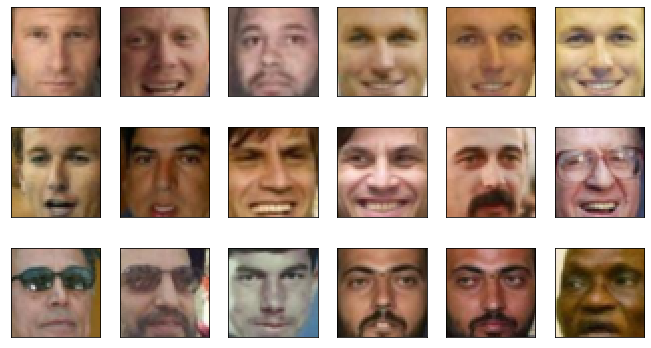

In [14]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [15]:
X_train = torch.FloatTensor(np.rollaxis(X_train, 3, 1) / 255)
X_val = torch.FloatTensor(np.rollaxis(X_val, 3, 1) / 255)


In [16]:
all_data = torch.FloatTensor(np.rollaxis(data, 3, 1) / 255)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [17]:
inp_size=X_train.shape[2]
dim_code = 0 # размер латентного вектора, т.е. code
inp_size

45

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [18]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, padding=1),
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, padding=1),
        )
        

        self.decoder1 = nn.Sequential(
            
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(16, 3, kernel_size=3,stride=2, padding=1),
            nn.Sigmoid(),
            nn.BatchNorm2d(3),
        )




    def forward(self, x):
        # encoder
        x = self.encoder1(x)
        #x = self.encoder2(x)
  
        code = x

        # decoder
        #x = self.decoder1(x)
        x = self.decoder2(x)


        '''реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        и полученная реконструкция изображения (reconstruction)'''

        return x, code

In [19]:
from torchsummary import summary

model = Autoencoder().to(device)

summary(model.to(device), (3, inp_size, inp_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 45, 45]             448
              ReLU-2           [-1, 16, 45, 45]               0
       BatchNorm2d-3           [-1, 16, 45, 45]              32
         MaxPool2d-4           [-1, 16, 23, 23]               0
   ConvTranspose2d-5            [-1, 3, 45, 45]             435
           Sigmoid-6            [-1, 3, 45, 45]               0
       BatchNorm2d-7            [-1, 3, 45, 45]               6
Total params: 921
Trainable params: 921
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.95
Params size (MB): 0.00
Estimated Total Size (MB): 0.97
----------------------------------------------------------------


Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [20]:
from IPython import display
def see_result(val, output):
    val = val.detach().numpy()
    output = output.detach().numpy()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(np.rollaxis(val, 0, 3))
    axes[1].imshow(np.rollaxis(output, 0, 3))
    fig.tight_layout()



def train(model, device, scheduler, optimizer, criterion, trainloader, valloader, epochs=50):

    losses = []
    val_losses = []
    
    for e in range(epochs):
        
        epoch_loss = []
        model.train()
        for image in trainloader:
            optimizer.zero_grad()

            output, code = model(image.to(device))

            loss = criterion(output, image.to(device))
            epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            val_epoch_loss = []
            for val in valloader:
                    
                output, code = model(val.to(device))
                val_epoch_loss.append( criterion(output, val.to(device)).cpu())
                                                    
            val_losses.append(np.mean(val_epoch_loss))
            losses.append(np.mean(epoch_loss)) 

            plt.pause(0.05)
            rand = np.random.randint(0, len(val))
            see_result(val[rand].cpu(), output[rand].cpu())
            plt.pause(0.05)
            print(f'Epoch {e+1}, Train Loss {losses[-1]}, Valid Loss {val_losses[-1]}, LR {scheduler.get_last_lr()[0]} ')
            scheduler.step()

    plt.plot(losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    return losses, val_losses

In [21]:
autoencoder = Autoencoder().to(device)

optimizer = torch.optim.AdamW(autoencoder.parameters(), amsgrad=True, lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.2)
criterion = nn.MSELoss()

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1000, shuffle = True)
val_loader = torch.utils.data.DataLoader(X_val, batch_size=3143)
all_data = torch.utils.data.DataLoader(data, batch_size=128, shuffle = True)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

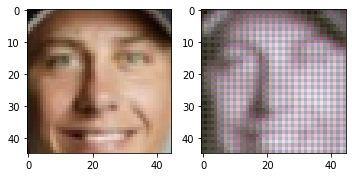

Epoch 1, Train Loss 0.9202599585056305, Valid Loss 0.02603764459490776, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


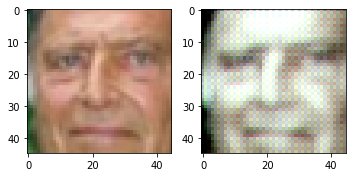

Epoch 2, Train Loss 0.6103519916534423, Valid Loss 0.05670970678329468, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


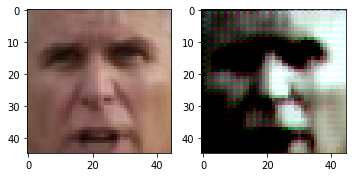

Epoch 3, Train Loss 0.4301917850971222, Valid Loss 0.1368410736322403, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


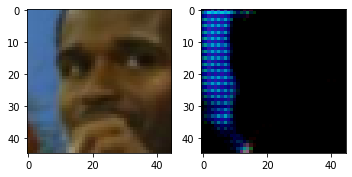

Epoch 4, Train Loss 0.2951366826891899, Valid Loss 0.15952090919017792, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


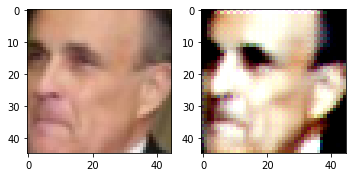

Epoch 5, Train Loss 0.19800308346748352, Valid Loss 0.12256915122270584, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


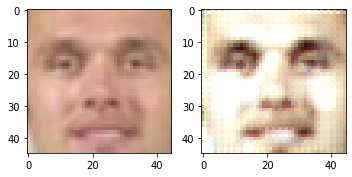

Epoch 6, Train Loss 0.13006322979927062, Valid Loss 0.0819421261548996, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


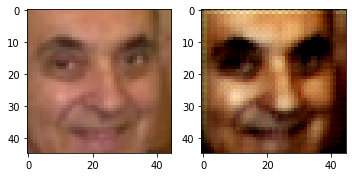

Epoch 7, Train Loss 0.08340797424316407, Valid Loss 0.05395245552062988, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


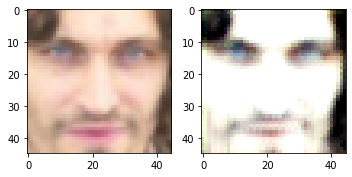

Epoch 8, Train Loss 0.05221322886645794, Valid Loss 0.03331868350505829, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


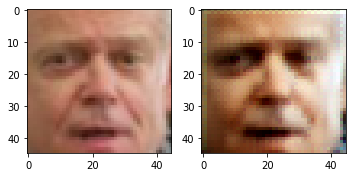

Epoch 9, Train Loss 0.03186942152678966, Valid Loss 0.020030464977025986, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


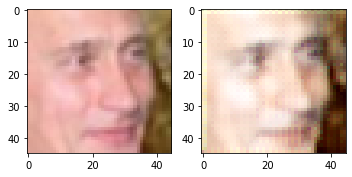

Epoch 10, Train Loss 0.019076708517968655, Valid Loss 0.011997953057289124, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


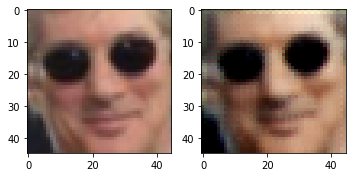

Epoch 11, Train Loss 0.011278365924954414, Valid Loss 0.007133068982511759, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


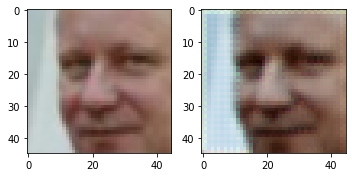

Epoch 12, Train Loss 0.006709197489544749, Valid Loss 0.004373298026621342, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


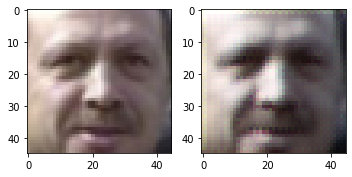

Epoch 13, Train Loss 0.004138934426009655, Valid Loss 0.0028518091421574354, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


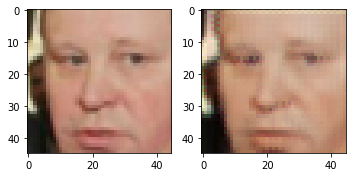

Epoch 14, Train Loss 0.0027574633480980993, Valid Loss 0.0020690446253865957, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


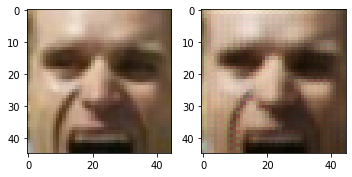

Epoch 15, Train Loss 0.002024047274608165, Valid Loss 0.001686533447355032, LR 0.01 


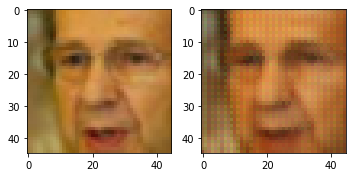

Epoch 16, Train Loss 0.0016580478753894568, Valid Loss 0.0016587923746556044, LR 0.01 


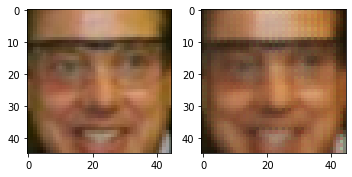

Epoch 17, Train Loss 0.0014805227052420377, Valid Loss 0.0013848587404936552, LR 0.01 


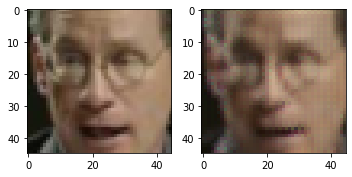

Epoch 18, Train Loss 0.0013838092563673854, Valid Loss 0.0013424779754132032, LR 0.01 


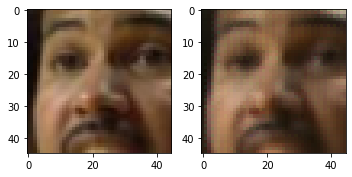

Epoch 19, Train Loss 0.0013400622643530368, Valid Loss 0.0013217601226642728, LR 0.01 


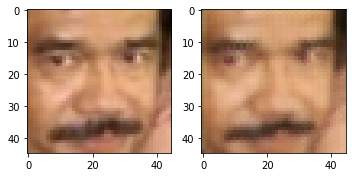

Epoch 20, Train Loss 0.001303374720737338, Valid Loss 0.0012959589948877692, LR 0.01 


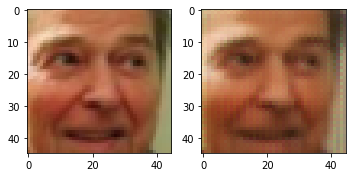

Epoch 21, Train Loss 0.001276197365950793, Valid Loss 0.0012705152621492743, LR 0.01 


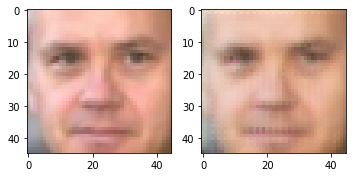

Epoch 22, Train Loss 0.0012537593487650157, Valid Loss 0.001253123627975583, LR 0.01 


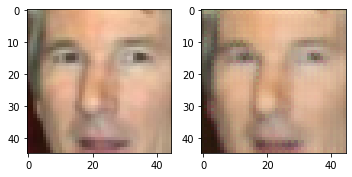

Epoch 23, Train Loss 0.0012299161055125297, Valid Loss 0.0012445520842447877, LR 0.01 


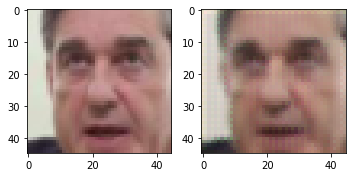

Epoch 24, Train Loss 0.0012065327260643243, Valid Loss 0.0012101137544959784, LR 0.01 


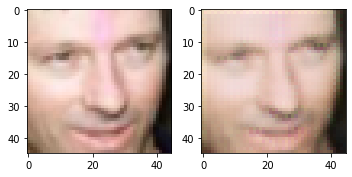

Epoch 25, Train Loss 0.001195100275799632, Valid Loss 0.0012161199701949954, LR 0.01 


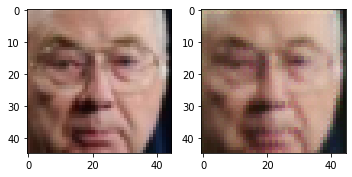

Epoch 26, Train Loss 0.0011668469407595694, Valid Loss 0.001231074915267527, LR 0.01 


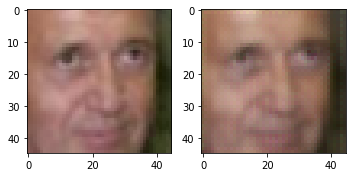

Epoch 27, Train Loss 0.0011443612864241004, Valid Loss 0.0012198283802717924, LR 0.01 


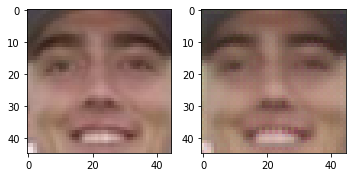

Epoch 28, Train Loss 0.0011236531310714782, Valid Loss 0.0012060125591233373, LR 0.01 


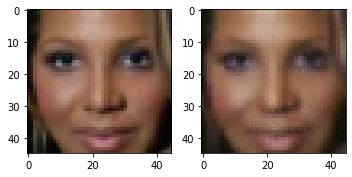

Epoch 29, Train Loss 0.0011018971214070915, Valid Loss 0.001163423410616815, LR 0.01 


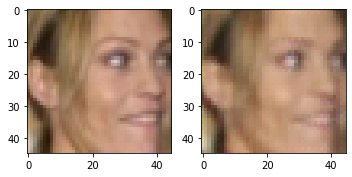

Epoch 30, Train Loss 0.001088164874818176, Valid Loss 0.0011916268849745393, LR 0.01 


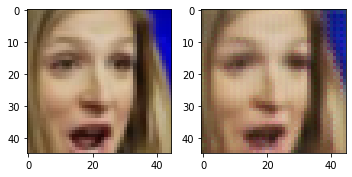

Epoch 31, Train Loss 0.0010602899012155831, Valid Loss 0.0013294985983520746, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


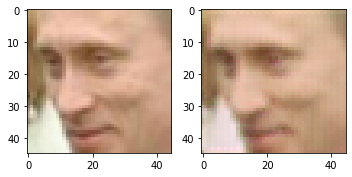

Epoch 32, Train Loss 0.0010400654282420874, Valid Loss 0.0012591977138072252, LR 0.01 


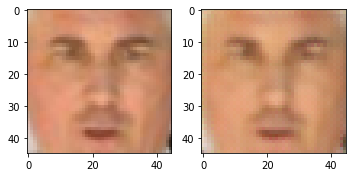

Epoch 33, Train Loss 0.001019869779702276, Valid Loss 0.0012229995336383581, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


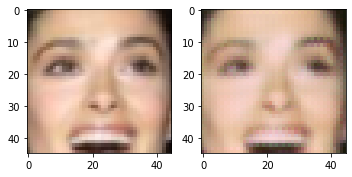

Epoch 34, Train Loss 0.0009913898655213415, Valid Loss 0.0012765737483277917, LR 0.01 


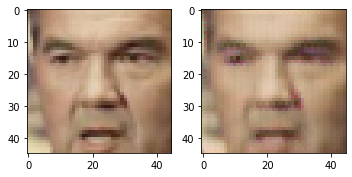

Epoch 35, Train Loss 0.0009683528216555715, Valid Loss 0.0011756818275898695, LR 0.01 


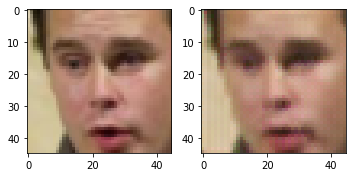

Epoch 36, Train Loss 0.0009483294445089996, Valid Loss 0.001227933564223349, LR 0.01 


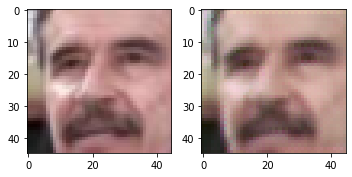

Epoch 37, Train Loss 0.0009219783591106534, Valid Loss 0.0009451049263589084, LR 0.01 


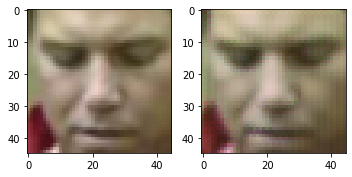

Epoch 38, Train Loss 0.0009015111019834876, Valid Loss 0.0009225084213539958, LR 0.01 


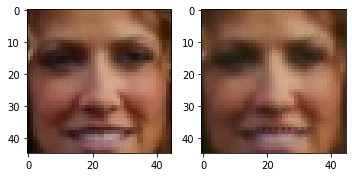

Epoch 39, Train Loss 0.000882904336322099, Valid Loss 0.0009038608986884356, LR 0.01 


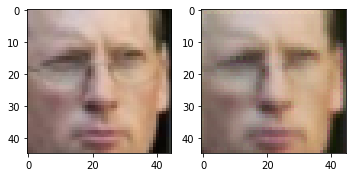

Epoch 40, Train Loss 0.0008640516083687544, Valid Loss 0.0008622188470326364, LR 0.01 


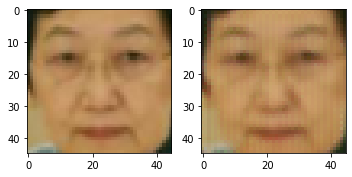

Epoch 41, Train Loss 0.0008382108819205314, Valid Loss 0.0008551228675059974, LR 0.01 


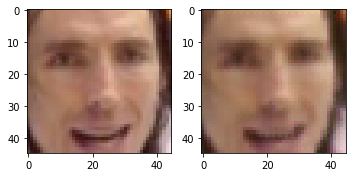

Epoch 42, Train Loss 0.000826815259642899, Valid Loss 0.0008763176156207919, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


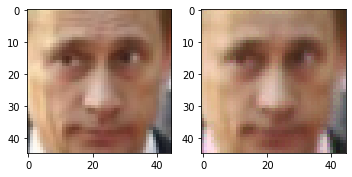

Epoch 43, Train Loss 0.0008033307385630906, Valid Loss 0.0008170827641151845, LR 0.01 


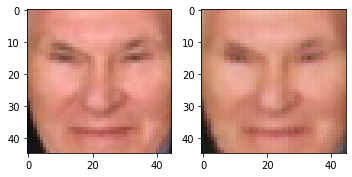

Epoch 44, Train Loss 0.0007864820305258036, Valid Loss 0.0007872223504818976, LR 0.01 


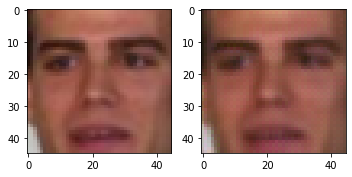

Epoch 45, Train Loss 0.0007705885509494692, Valid Loss 0.000789287150837481, LR 0.01 


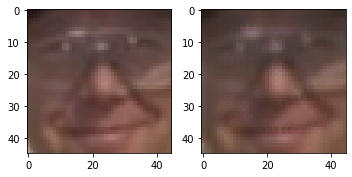

Epoch 46, Train Loss 0.0007615174748934805, Valid Loss 0.0007509910501539707, LR 0.01 


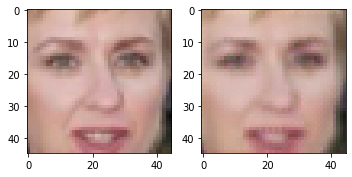

Epoch 47, Train Loss 0.000740570918424055, Valid Loss 0.0007387303048744798, LR 0.01 


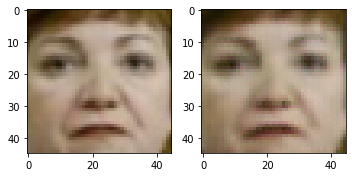

Epoch 48, Train Loss 0.0007315934111829847, Valid Loss 0.0007187273586168885, LR 0.01 


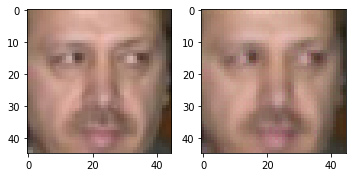

Epoch 49, Train Loss 0.0007155289989896118, Valid Loss 0.0007094285683706403, LR 0.01 


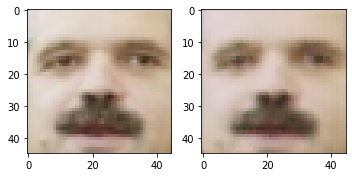

Epoch 50, Train Loss 0.0007125963340513409, Valid Loss 0.0006908540381118655, LR 0.01 


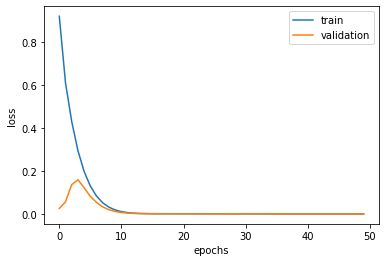

In [22]:
train_loss, val_loss = train(autoencoder, device, scheduler, optimizer, criterion, train_loader, val_loader, epochs= 50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3143, 16, 23, 23)

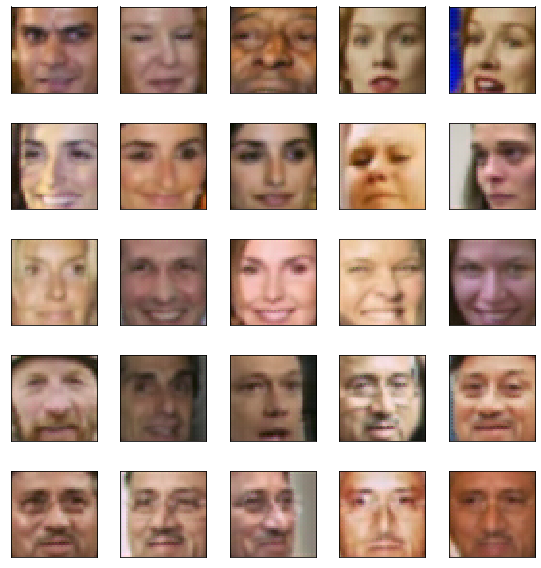

In [23]:
x_val = next(iter(val_loader))
y_pred, code = autoencoder(x_val.to(device))
code = code.cpu().detach().numpy()

y_pred = np.rollaxis(y_pred.data.cpu().numpy(), 1 , 4)
plot_gallery(y_pred, IMAGE_H, IMAGE_W, n_row=5, n_col=5)
code.shape

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

In [24]:
#к сожалению, на conv декодере не получилось создать новые лица. Однако это вышло, если использовать fully-connected архитектуру 

class LinearAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder1 = nn.Sequential(
            nn.Linear(45 * 45 * 3, 3000),
            nn.Tanh(),
            nn.BatchNorm1d(3000),
            
        )
        

        self.decoder1 = nn.Sequential(
            

            nn.Linear( 3000, 45 * 45 * 3),
            nn.Tanh(),
            nn.BatchNorm1d(45 * 45 * 3)
        )

    def forward(self, x):
        # encoder
        x = x.view(-1, 45 * 45 * 3)
        x = self.encoder1(x)
     
  
        code = x

        # decoder
        x = self.decoder1(x)


        '''реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        и полученная реконструкция изображения (reconstruction)'''

        return x.view(-1, 3, 45, 45), code


In [25]:
linear_ae = LinearAE().to(device)
optimizer = torch.optim.AdamW(linear_ae.parameters(), amsgrad=True, lr = 0.01)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


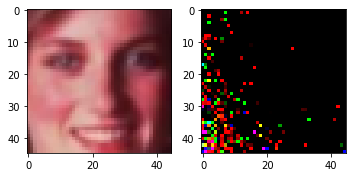

Epoch 1, Train Loss 1.023624438047409, Valid Loss 2.876551389694214, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


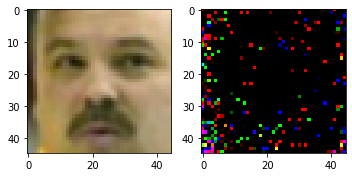

Epoch 2, Train Loss 0.7311886727809906, Valid Loss 2.6098899841308594, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


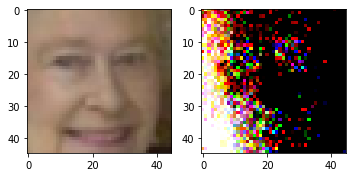

Epoch 3, Train Loss 0.5343871295452118, Valid Loss 1.9914695024490356, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


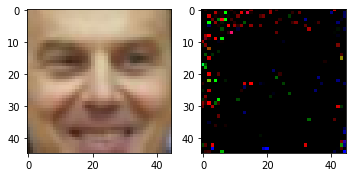

Epoch 4, Train Loss 0.3842795491218567, Valid Loss 1.3086557388305664, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


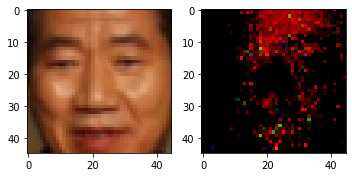

Epoch 5, Train Loss 0.27227444350719454, Valid Loss 0.44630298018455505, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


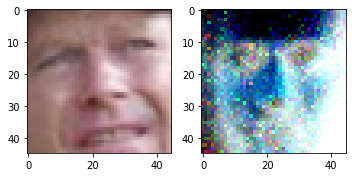

Epoch 6, Train Loss 0.19166781306266784, Valid Loss 0.27291837334632874, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


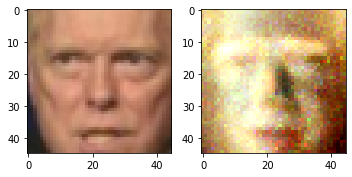

Epoch 7, Train Loss 0.13366416692733765, Valid Loss 0.11600159853696823, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


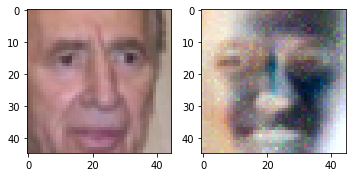

Epoch 8, Train Loss 0.09214900508522987, Valid Loss 0.09992992132902145, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


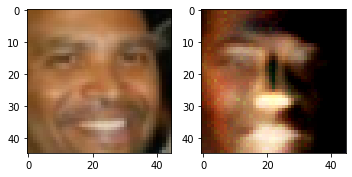

Epoch 9, Train Loss 0.06337912529706954, Valid Loss 0.06993644684553146, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


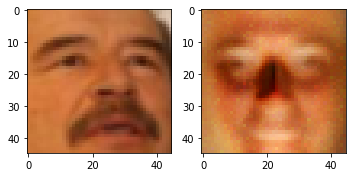

Epoch 10, Train Loss 0.04409717731177807, Valid Loss 0.0467815101146698, LR 0.01 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


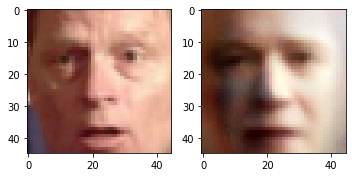

Epoch 11, Train Loss 0.031788557022809985, Valid Loss 0.028381315991282463, LR 0.01 


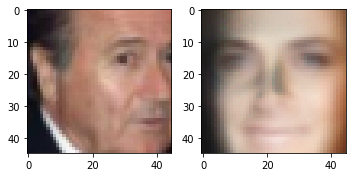

Epoch 12, Train Loss 0.02380747739225626, Valid Loss 0.027149902656674385, LR 0.01 


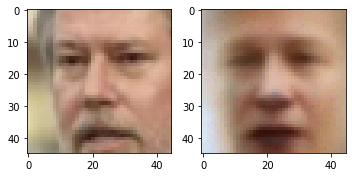

Epoch 13, Train Loss 0.018761612474918365, Valid Loss 0.01931970939040184, LR 0.01 


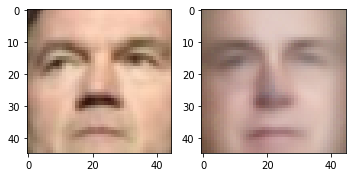

Epoch 14, Train Loss 0.016015335731208325, Valid Loss 0.015239929780364037, LR 0.01 


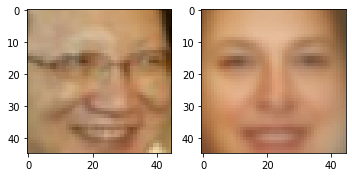

Epoch 15, Train Loss 0.014449899643659591, Valid Loss 0.014630245976150036, LR 0.01 


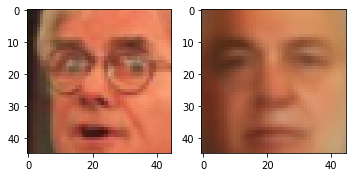

Epoch 16, Train Loss 0.013418766763061285, Valid Loss 0.014715105295181274, LR 0.01 


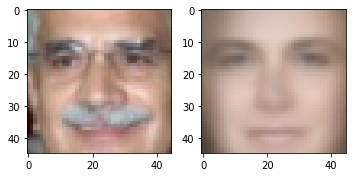

Epoch 17, Train Loss 0.012891243398189544, Valid Loss 0.014400999061763287, LR 0.01 


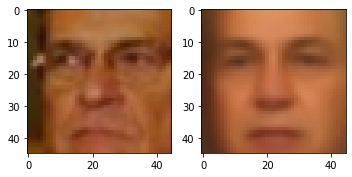

Epoch 18, Train Loss 0.01250645164400339, Valid Loss 0.013451301492750645, LR 0.01 


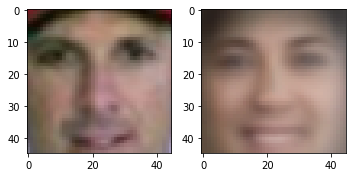

Epoch 19, Train Loss 0.012329261284321547, Valid Loss 0.01289287768304348, LR 0.01 


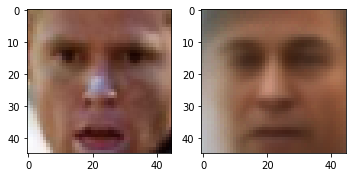

Epoch 20, Train Loss 0.012133063655346632, Valid Loss 0.013911096379160881, LR 0.01 


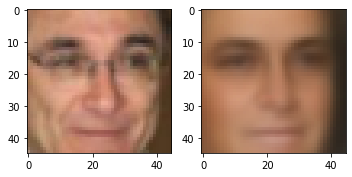

Epoch 21, Train Loss 0.012039650231599808, Valid Loss 0.01280205324292183, LR 0.01 


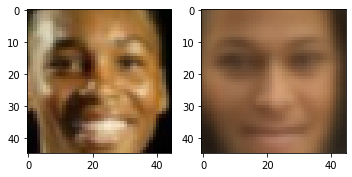

Epoch 22, Train Loss 0.01203089887276292, Valid Loss 0.012849299237132072, LR 0.01 


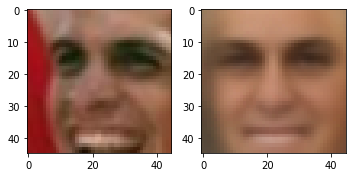

Epoch 23, Train Loss 0.011988068185746669, Valid Loss 0.012936713173985481, LR 0.01 


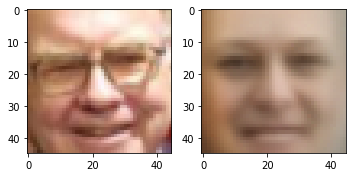

Epoch 24, Train Loss 0.011930122971534729, Valid Loss 0.013107349164783955, LR 0.01 


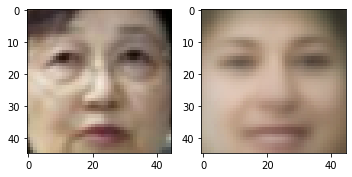

Epoch 25, Train Loss 0.011892683990299701, Valid Loss 0.01284717209637165, LR 0.01 


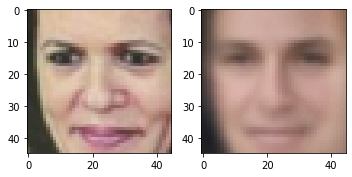

Epoch 26, Train Loss 0.011805604957044125, Valid Loss 0.012982761487364769, LR 0.01 


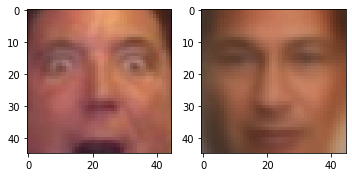

Epoch 27, Train Loss 0.011733778845518827, Valid Loss 0.012714514508843422, LR 0.01 


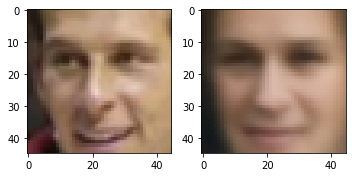

Epoch 28, Train Loss 0.01170598454773426, Valid Loss 0.013295404613018036, LR 0.01 


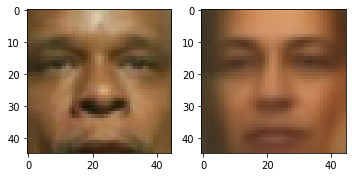

Epoch 29, Train Loss 0.011731183622032404, Valid Loss 0.013362627476453781, LR 0.01 


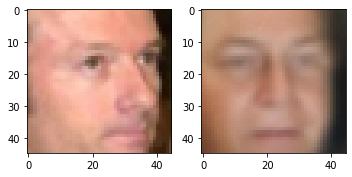

Epoch 30, Train Loss 0.011752551607787608, Valid Loss 0.012464167550206184, LR 0.01 


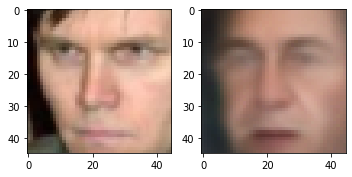

Epoch 31, Train Loss 0.01155357863754034, Valid Loss 0.012284956872463226, LR 0.01 


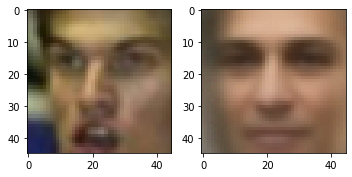

Epoch 32, Train Loss 0.011476974561810493, Valid Loss 0.012358592823147774, LR 0.01 


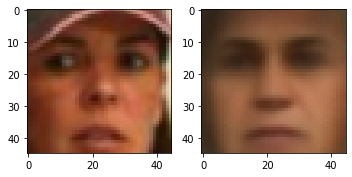

Epoch 33, Train Loss 0.011439507827162743, Valid Loss 0.012884627096354961, LR 0.01 


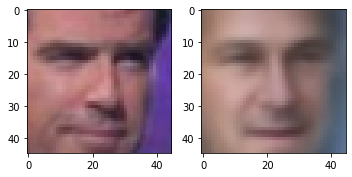

Epoch 34, Train Loss 0.01155988099053502, Valid Loss 0.013119124807417393, LR 0.01 


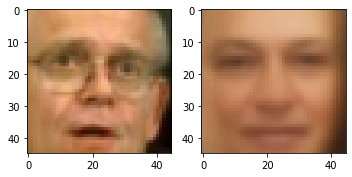

Epoch 35, Train Loss 0.01164851589128375, Valid Loss 0.0133985485881567, LR 0.01 


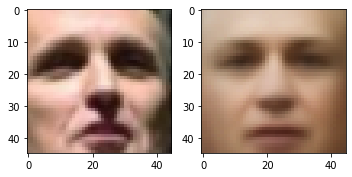

Epoch 36, Train Loss 0.011555709596723317, Valid Loss 0.012172563001513481, LR 0.01 


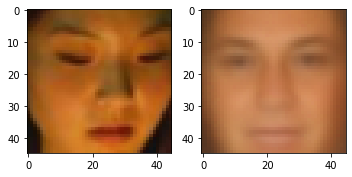

Epoch 37, Train Loss 0.011455084756016731, Valid Loss 0.012907001189887524, LR 0.01 


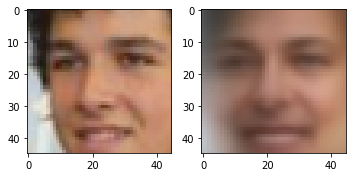

Epoch 38, Train Loss 0.011387723870575428, Valid Loss 0.01207153219729662, LR 0.01 


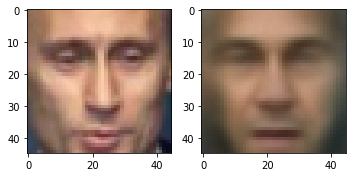

Epoch 39, Train Loss 0.011545228119939566, Valid Loss 0.013598124496638775, LR 0.01 


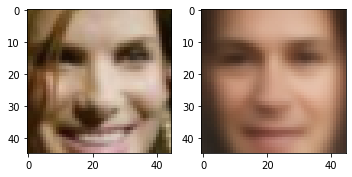

Epoch 40, Train Loss 0.011272800527513028, Valid Loss 0.012419909238815308, LR 0.01 


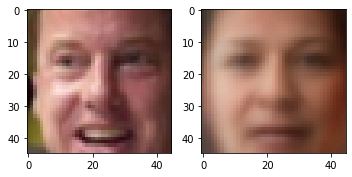

Epoch 41, Train Loss 0.011150562297552824, Valid Loss 0.01241812203079462, LR 0.01 


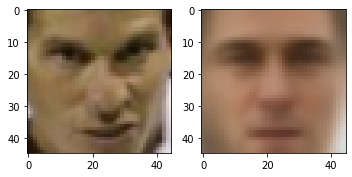

Epoch 42, Train Loss 0.01113013569265604, Valid Loss 0.012208694592118263, LR 0.01 


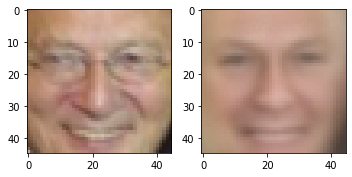

Epoch 43, Train Loss 0.011078180279582739, Valid Loss 0.012648830190300941, LR 0.01 


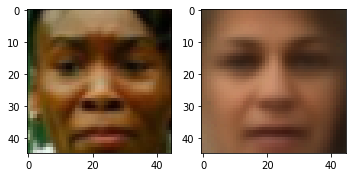

Epoch 44, Train Loss 0.011249177623540163, Valid Loss 0.013495217077434063, LR 0.01 


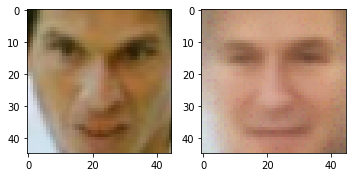

Epoch 45, Train Loss 0.011597379483282566, Valid Loss 0.019854554906487465, LR 0.01 


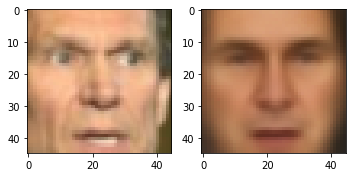

Epoch 46, Train Loss 0.011913362890481949, Valid Loss 0.013785099610686302, LR 0.01 


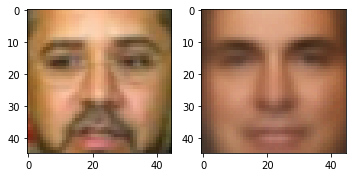

Epoch 47, Train Loss 0.01191727351397276, Valid Loss 0.013763234950602055, LR 0.01 


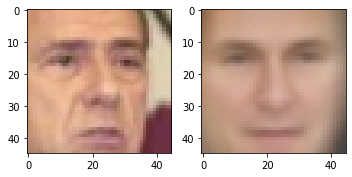

Epoch 48, Train Loss 0.011682177241891623, Valid Loss 0.013842148706316948, LR 0.01 


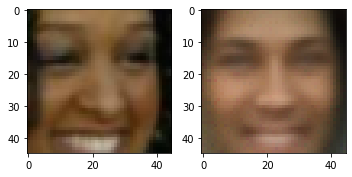

Epoch 49, Train Loss 0.01175650767982006, Valid Loss 0.013489123433828354, LR 0.01 


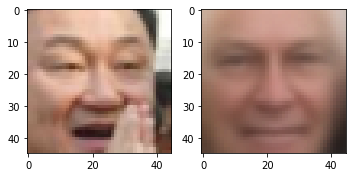

Epoch 50, Train Loss 0.011567791923880577, Valid Loss 0.012567007914185524, LR 0.01 


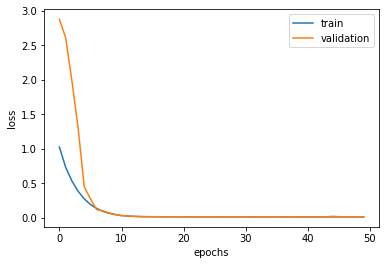

In [26]:
train_loss, val_loss = train(linear_ae, device, scheduler, optimizer, criterion, train_loader, val_loader, epochs= 50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

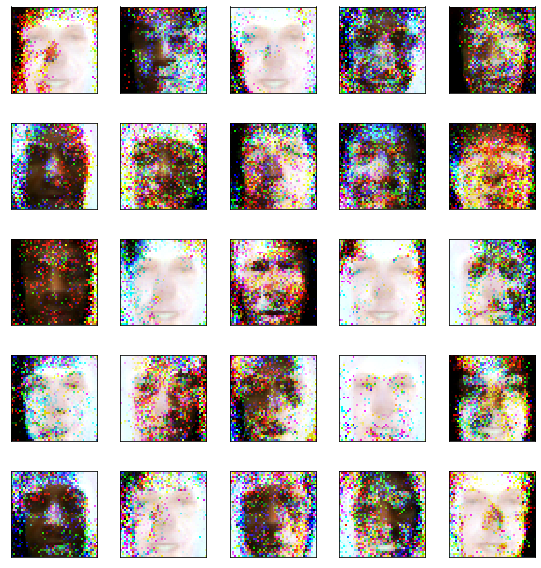

In [27]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, 3000)
z = torch.FloatTensor(z).to(device)
output = linear_ae.decoder1(z).view(-1, 3, 45, 45)
output = np.rollaxis(output.data.cpu().numpy(), 1, 4)


plot_gallery(output, IMAGE_H, IMAGE_W, n_row=5, n_col=5)


## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [28]:
smiles = torch.stack([
     X_train[1],
     X_train[3],
     X_train[4],
     X_train[5],
     X_train[8],
     X_train[9],
     X_train[11],
     X_train[26],
     X_train[34],
     X_train[60],
     X_train[58],
     X_train[83],
     X_train[88],
     X_train[96],
     X_train[98],
])
nosmiles = torch.stack([
     X_train[0],
     X_train[2],
     X_train[7],
     X_train[12],
     X_train[14],
     X_train[21],
     X_train[22],
     X_train[23],
     X_train[24],
     X_train[35],
     X_train[52], 
     X_train[54],
     X_train[55],
     X_train[61], 
     X_train[62],                          
])


In [29]:
encoder = autoencoder.encoder1
decoder = autoencoder.decoder2
smiles_codes = encoder(smiles.to(device)).detach()
nosmiles_codes = encoder(nosmiles.to(device)).detach()
SMILE = smiles_codes.mean(dim=0) - nosmiles_codes.mean(dim=0)

ДО


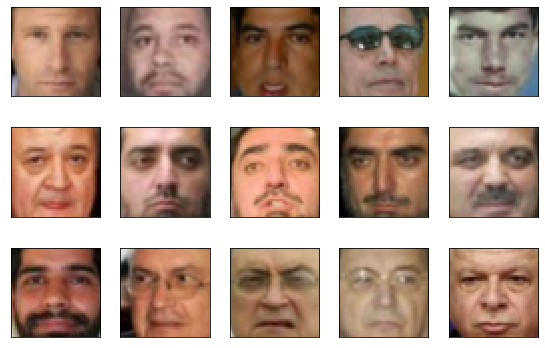

In [30]:
result = decoder(nosmiles_codes + SMILE)
print('ДО')
plot_gallery(np.rollaxis(nosmiles.data.cpu().numpy(), 1 , 4), IMAGE_H, IMAGE_W, n_col=5, n_row=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


После


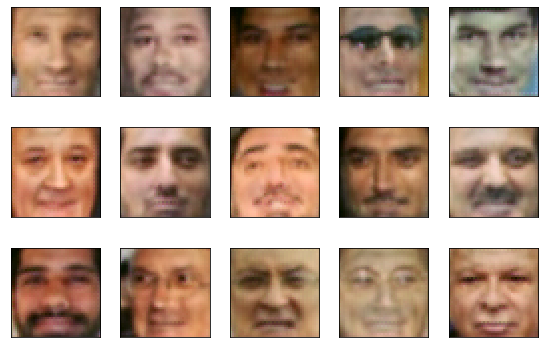

In [31]:
print('После')
plot_gallery(np.rollaxis(result.data.cpu().numpy(), 1 , 4), IMAGE_H, IMAGE_W, n_col=5, n_row=3)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [5]:
class LinearVAE(nn.Module):
    def __init__(self, inp):
        '''определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma'''

        super().__init__()
        self.inp = inp
        self.fc1 = nn.Linear(inp*inp,500)
        self.fc_sig = nn.Linear(500, 100)
        self.fc_mu = nn.Linear(500, 100)
        
        self.fc3 = nn.Linear(100, 500)
        self.fc4 = nn.Linear(500, inp*inp)

    def encode(self, x):
        '''реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma'''
        eps = 1e-5

        x = x.view(-1, self.inp * self.inp )
        x = F.relu(self.fc1(x))
        mu = F.relu(self.fc_mu(x[:]))
        logsigma = torch.log(F.relu(self.fc_sig(x)) + eps)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu


    def decode(self, z):
        '''реализуйте forward проход декодера
        в качестве ваозвращаемой переменной -- reconstruction'''

        z = F.relu(self.fc3(z))
        reconstruction = F.sigmoid(self.fc4(z))
        return reconstruction

    def forward(self, x):
        '''<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>'''

        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        

        return mu, logsigma, reconstruction.view(-1, 1, self.inp, self.inp)

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [6]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    sigma = logsigma.exp()
    loss = (-0.5)*(1+2*logsigma-mu*mu-sigma*sigma)
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(size_average=False, reduce='none')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return (-KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)).mean()


И обучим модель:

In [7]:
def see_result(val, output):
    val = val.detach().numpy()
    output = output.detach().numpy()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(val.reshape(28, 28), cmap='gray')
    axes[1].imshow(output.reshape(28, 28), cmap='gray')
    fig.tight_layout()



def vae_train(model, device, optimizer, criterion, trainloader, valloader, epochs=50):

    losses = []
    val_losses = []
    val_fn = nn.MSELoss()
    for e in range(epochs):
        
        epoch_loss = []
        model.train()
        for image, _ in trainloader:
            optimizer.zero_grad()
         
            mu, logsigma, reconstruction = model(image.to(device))
            loss = criterion(image.to(device), mu, logsigma, reconstruction)
            epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        

        model.eval()
        with torch.no_grad():
            val_epoch_loss = []
            for val, _ in valloader:
                    
                mu, logsigma, reconstruction = model(val.to(device))
                
                
                val_epoch_loss.append( val_fn(  reconstruction, val.to(device)).item())
            
            val_losses.append(np.mean(val_epoch_loss))
            losses.append(np.mean(epoch_loss)) 

            plt.pause(0.05)
            rand = np.random.randint(0, len(val))
            see_result(val[rand].cpu(), reconstruction[rand].cpu())
            plt.pause(0.05)
            print(f'Epoch {e+1}, Train Loss {losses[-1]}, Valid Loss {val_losses[-1]} ')

    plt.plot(losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    return losses, val_losses

In [8]:
criterion = loss_vae
vae = LinearVAE(28).to(device)

optimizer = torch.optim.AdamW(vae.parameters(), amsgrad=True, lr = 0.01)

In [9]:
from torchvision import transforms
from torchvision import datasets

transform = transforms.Compose([transforms.ToTensor(), ])

mnist_tr = datasets.MNIST('', download=True, train=True, transform=transform)
mnist_val = datasets.MNIST('', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_tr, batch_size=5000, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=5000, shuffle=True)

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


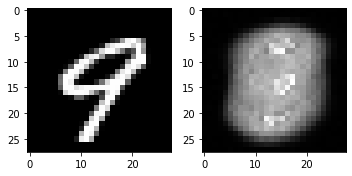

Epoch 1, Train Loss 1626646.84375, Valid Loss 0.07533397153019905 


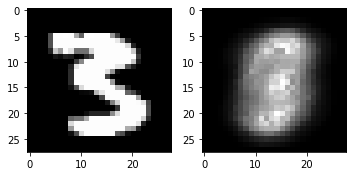

Epoch 2, Train Loss 1043923.9114583334, Valid Loss 0.06659263744950294 


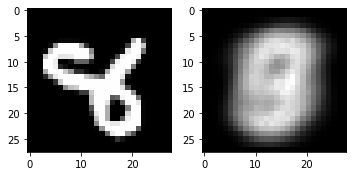

Epoch 3, Train Loss 987169.6875, Valid Loss 0.062273114919662476 


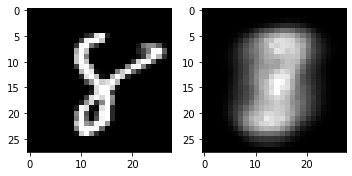

Epoch 4, Train Loss 948607.265625, Valid Loss 0.05860144458711147 


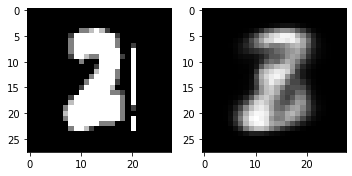

Epoch 5, Train Loss 899072.3020833334, Valid Loss 0.05373595654964447 


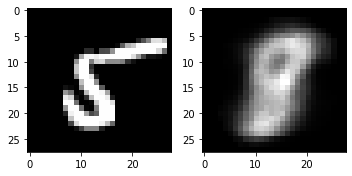

Epoch 6, Train Loss 844457.1510416666, Valid Loss 0.04792127199470997 


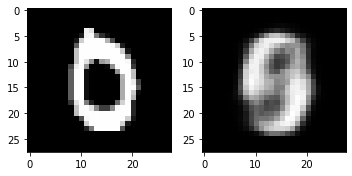

Epoch 7, Train Loss 774733.1614583334, Valid Loss 0.04356331564486027 


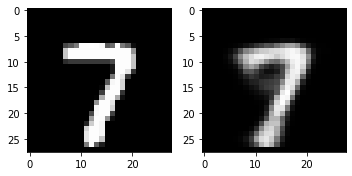

Epoch 8, Train Loss 727631.0833333334, Valid Loss 0.03897737339138985 


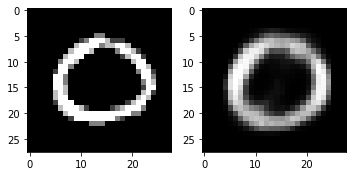

Epoch 9, Train Loss 683420.5208333334, Valid Loss 0.03531682305037975 


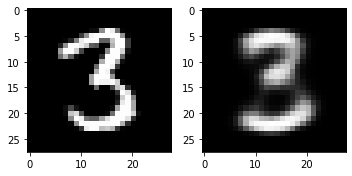

Epoch 10, Train Loss 641888.8020833334, Valid Loss 0.03180733136832714 


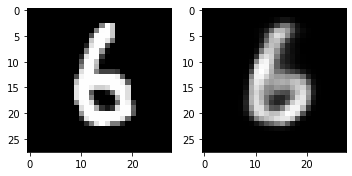

Epoch 11, Train Loss 618692.4322916666, Valid Loss 0.030143327079713345 


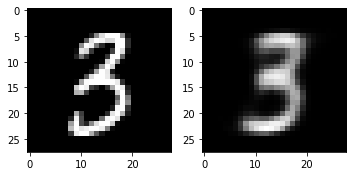

Epoch 12, Train Loss 597491.4270833334, Valid Loss 0.028673823922872543 


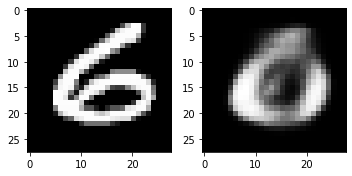

Epoch 13, Train Loss 568479.96875, Valid Loss 0.026093007065355778 


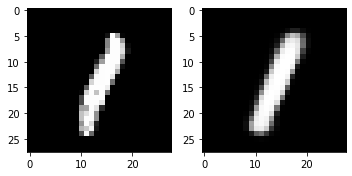

Epoch 14, Train Loss 563320.7916666666, Valid Loss 0.026227407157421112 


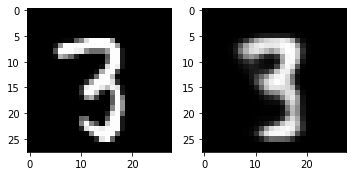

Epoch 15, Train Loss 543194.6302083334, Valid Loss 0.0238925414159894 


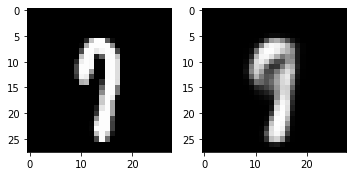

Epoch 16, Train Loss 519606.3072916667, Valid Loss 0.0222890367731452 


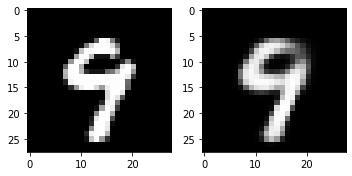

Epoch 17, Train Loss 503093.4427083333, Valid Loss 0.020837487652897835 


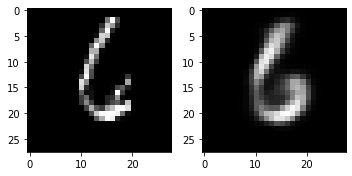

Epoch 18, Train Loss 531766.5833333334, Valid Loss 0.02655647788196802 


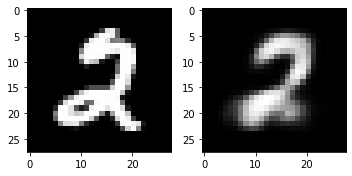

Epoch 19, Train Loss 551243.6822916666, Valid Loss 0.024034646339714527 


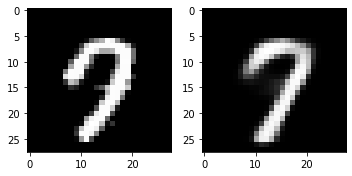

Epoch 20, Train Loss 507775.9427083333, Valid Loss 0.020268186926841736 


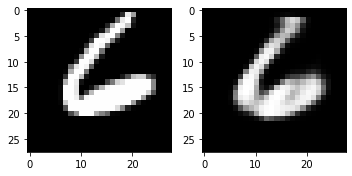

Epoch 21, Train Loss 478687.421875, Valid Loss 0.01862348709255457 


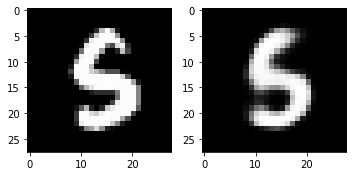

Epoch 22, Train Loss 463429.1822916667, Valid Loss 0.01766080129891634 


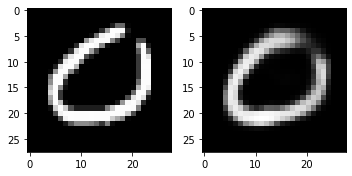

Epoch 23, Train Loss 460947.2109375, Valid Loss 0.018689324147999287 


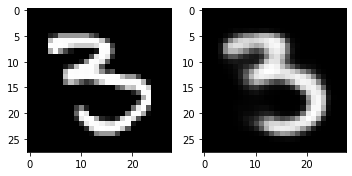

Epoch 24, Train Loss 455129.1901041667, Valid Loss 0.016674814745783806 


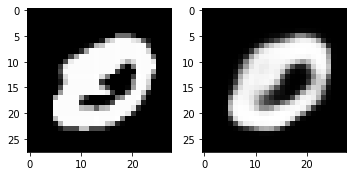

Epoch 25, Train Loss 440684.2109375, Valid Loss 0.01580682396888733 


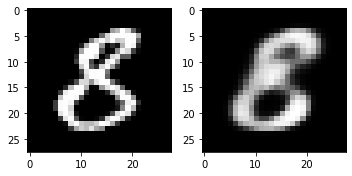

Epoch 26, Train Loss 454817.7083333333, Valid Loss 0.017131262458860874 


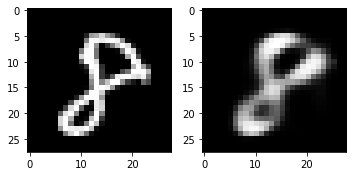

Epoch 27, Train Loss 437620.6692708333, Valid Loss 0.015172767452895641 


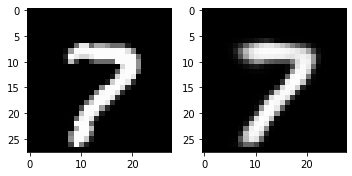

Epoch 28, Train Loss 423817.5234375, Valid Loss 0.014942209236323833 


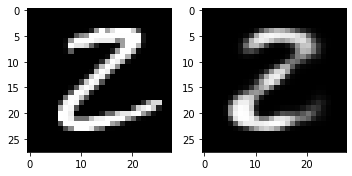

Epoch 29, Train Loss 419785.7109375, Valid Loss 0.016267436556518078 


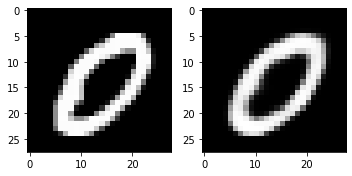

Epoch 30, Train Loss 425790.5859375, Valid Loss 0.014275992289185524 


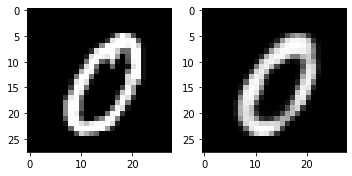

Epoch 31, Train Loss 409062.2473958333, Valid Loss 0.013376456685364246 


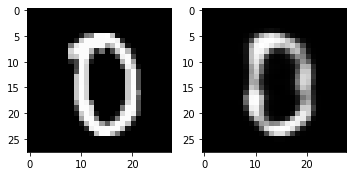

Epoch 32, Train Loss 418830.5625, Valid Loss 0.014952822122722864 


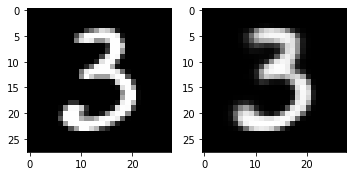

Epoch 33, Train Loss 424220.8359375, Valid Loss 0.013734288513660431 


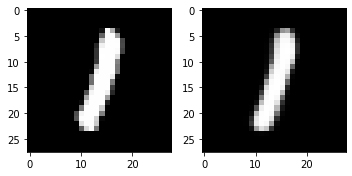

Epoch 34, Train Loss 403089.6536458333, Valid Loss 0.01273418078199029 


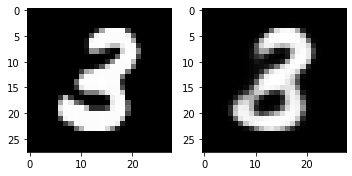

Epoch 35, Train Loss 392713.9427083333, Valid Loss 0.012775734532624483 


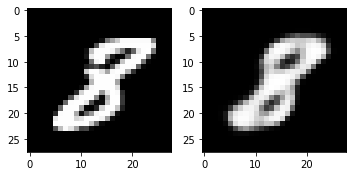

Epoch 36, Train Loss 397273.5104166667, Valid Loss 0.01196613535284996 


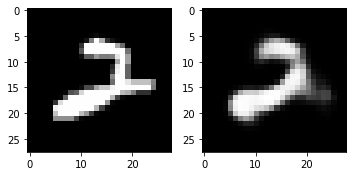

Epoch 37, Train Loss 385342.5234375, Valid Loss 0.0114602274261415 


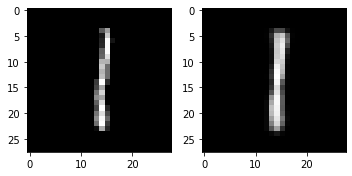

Epoch 38, Train Loss 416051.4140625, Valid Loss 0.015081718564033508 


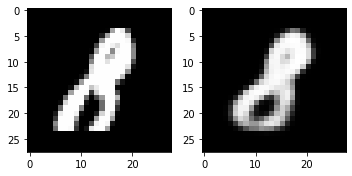

Epoch 39, Train Loss 416358.1588541667, Valid Loss 0.013045156374573708 


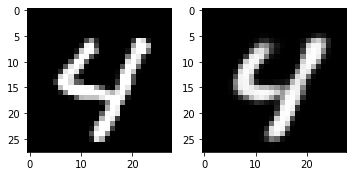

Epoch 40, Train Loss 388838.1588541667, Valid Loss 0.011308698449283838 


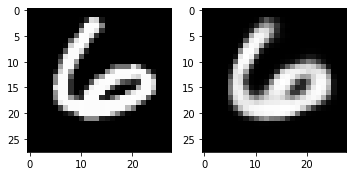

Epoch 41, Train Loss 378775.1822916667, Valid Loss 0.010968551505357027 


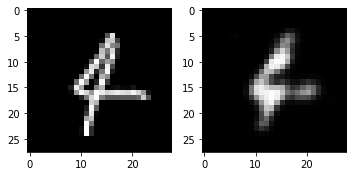

Epoch 42, Train Loss 373113.953125, Valid Loss 0.01048798393458128 


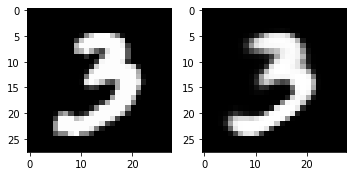

Epoch 43, Train Loss 367412.5364583333, Valid Loss 0.010205551981925964 


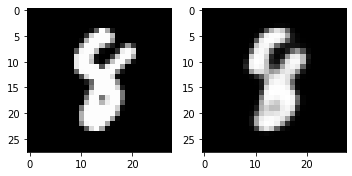

Epoch 44, Train Loss 394934.34375, Valid Loss 0.012583945412188768 


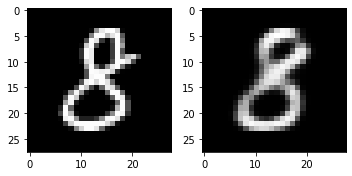

Epoch 45, Train Loss 382818.7005208333, Valid Loss 0.010851598810404539 


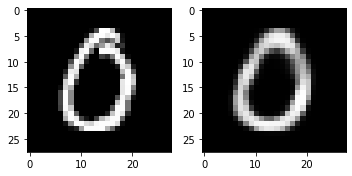

Epoch 46, Train Loss 367175.1510416667, Valid Loss 0.010029843542724848 


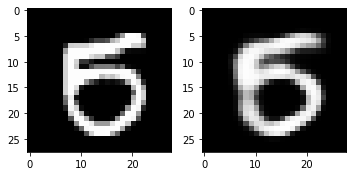

Epoch 47, Train Loss 364245.0234375, Valid Loss 0.010865996591746807 


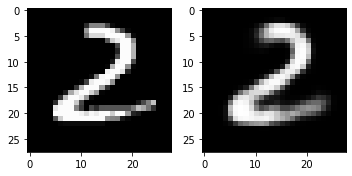

Epoch 48, Train Loss 364319.4895833333, Valid Loss 0.009706160984933376 


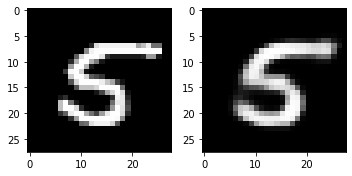

Epoch 49, Train Loss 357611.34375, Valid Loss 0.00947289215400815 


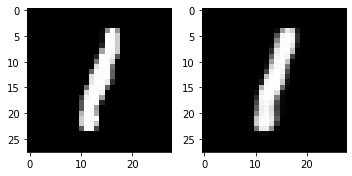

Epoch 50, Train Loss 363150.4296875, Valid Loss 0.01248201634734869 


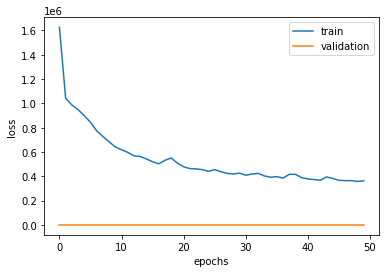

In [10]:
train_loss, val_loss = vae_train(vae, device,  optimizer, criterion, train_loader, val_loader, epochs= 50)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ДО


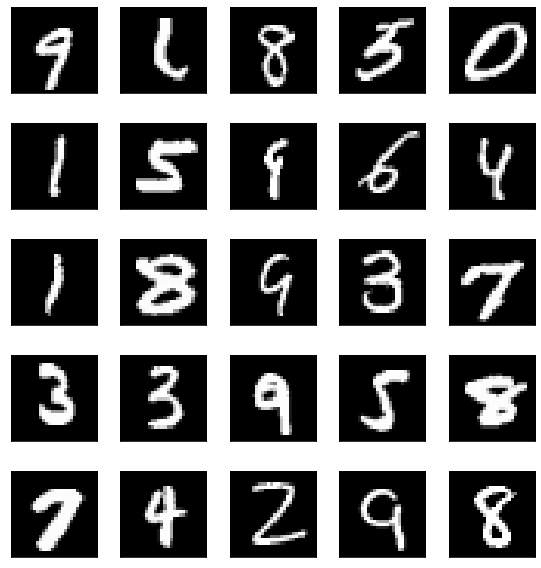

In [11]:
x_val, _ = next(iter(val_loader))
mu, logsigma, reconstruction = vae(x_val.to(device))
y_pred = reconstruction.data.cpu().numpy().reshape(-1, 28, 28)

print('ДО')
plot_gallery(x_val.data.cpu().numpy().reshape(-1, 28, 28), 28, 28, n_row=5, n_col=5, channels=1)

ПОСЛЕ


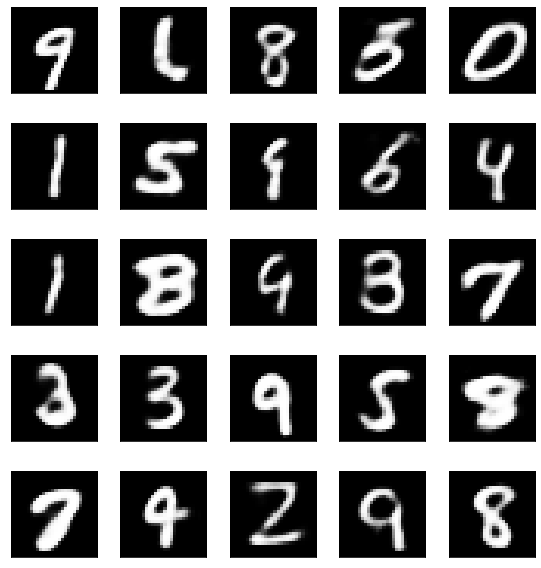

In [12]:
print('ПОСЛЕ')
plot_gallery(y_pred, 28, 28, n_row=5, n_col=5, channels=1)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


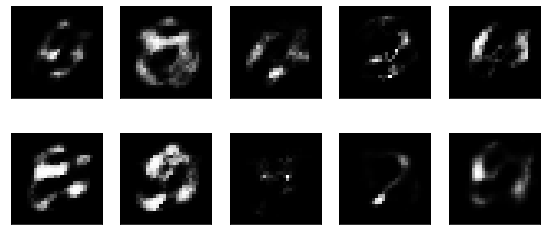

In [13]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
output = vae.decode(torch.FloatTensor(z).to(device))
out = output.data.cpu().numpy().reshape(-1, 28, 28)
plot_gallery(output.data.cpu().numpy().reshape(-1, 28, 28), 28, 28, n_row=2, n_col=5, channels=1)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [14]:
!pip install scipy==1.4.0

  Using cached https://files.pythonhosted.org/packages/f0/7a/579f4659bb488f19f6b458a003b36b86bacaedcb28530f8d25cb153fc5cd/scipy-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.4.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.0.0
    Uninstalling scipy-1.0.0:
      Successfully uninstalled scipy-1.0.0


In [15]:
from sklearn.manifold import TSNE as TSNE

In [16]:
image, label = next(iter(val_loader))
mu, logsigma = vae.encode(image.to(device))
logsigma = logsigma.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()

tsne1 = TSNE().fit_transform(mu)
#tsne2 = TSNE().fit_transform(logsigma)

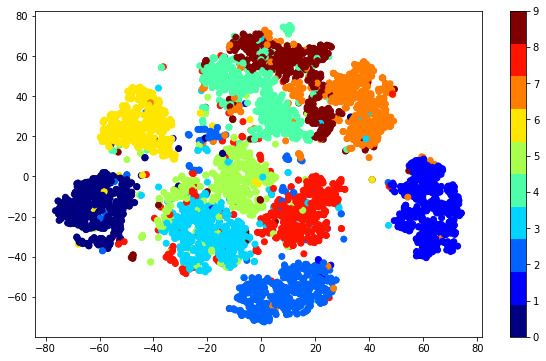

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(tsne1[:,0], tsne1[:,1], c=label, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar( )
plt.show()

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [39]:
def onehot_digits():
        result = []
        for dig in range(10):
            one_hot = [0 for i in range(10)]
            one_hot[dig] = 1
            result.append(one_hot)
        return torch.FloatTensor(result).to(device)

onehot_digits()[2]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [90]:
class CVAE(nn.Module):
    def __init__(self, inp):
        '''определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma'''

        super().__init__()
        self.inp = inp
        self.fc1 = nn.Linear(inp*inp+10,500)
        self.fc_sig = nn.Linear(500, 100)
        self.fc_mu = nn.Linear(500, 100)
        
        self.fc3 = nn.Linear(100+10, 500)
        self.fc4 = nn.Linear(500, inp*inp)
    
    def onehot_digits(self):
        result = []
        for dig in range(10):
            one_hot = [0 for i in range(10)]
            one_hot[dig] = 1
            result.append(one_hot)
        return torch.FloatTensor(result).to(device)

    def encode(self, x, label):
        '''реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma'''
        eps = 1e-5

        x = x.view(-1, self.inp * self.inp )
        x = torch.cat( (x, label.float()), dim=1)
        x = F.relu(self.fc1(x))
        mu = F.relu(self.fc_mu(x[:]))
        logsigma = torch.log(F.relu(self.fc_sig(x)) + eps)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z, label):
        '''реализуйте forward проход декодера
        в качестве ваозвращаемой переменной -- reconstruction'''
        z = torch.cat( (z, label.float()), dim=1)
        
        z = F.relu(self.fc3(z))
        reconstruction = F.sigmoid(self.fc4(z))
        return reconstruction

    def forward(self, x, label):
        '''<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>'''
        digits = self.onehot_digits()
        digit = digits[label].view(-1, 10)
        mu, logsigma = self.encode(x, digit)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, digit)
        

        return mu, logsigma, reconstruction.view(-1, 1, self.inp, self.inp)

In [91]:
def see_result(val, output):
    val = val.detach().numpy()
    output = output.detach().numpy()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(val.reshape(28, 28), cmap='gray')
    axes[1].imshow(output.reshape(28, 28), cmap='gray')
    fig.tight_layout()


def cvae_train(model, device, optimizer, criterion, trainloader, valloader, epochs=50):

    losses = []
    val_losses = []
    val_fn = nn.MSELoss()
    for e in range(epochs):
        
        epoch_loss = []
        model.train()
        for image, label in trainloader:
            optimizer.zero_grad()
         
            mu, logsigma, reconstruction = model(image.to(device), label.to(device))
            loss = criterion(image.to(device), mu, logsigma, reconstruction)
            epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        

        model.eval()
        with torch.no_grad():
            val_epoch_loss = []
            for val, label in valloader:                    
                mu, logsigma, reconstruction = model(val.to(device), label.to(device))               
                val_epoch_loss.append( val_fn(  reconstruction, val.to(device)).item())
            
            val_losses.append(np.mean(val_epoch_loss))
            losses.append(np.mean(epoch_loss)) 

            plt.pause(0.05)
            rand = np.random.randint(0, len(val))
            see_result(val[rand].cpu(), reconstruction[rand].cpu())
            plt.pause(0.05)
            print(f'Epoch {e+1}, Train Loss {losses[-1]}, Valid Loss {val_losses[-1]} ')

    plt.plot(losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    return losses, val_losses

In [92]:
from torchvision import transforms
from torchvision import datasets

transform = transforms.Compose([transforms.ToTensor(), ])

mnist_tr = datasets.MNIST('', download=True, train=True, transform=transform)
mnist_val = datasets.MNIST('', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_tr, batch_size=5000, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=5000, shuffle=True)

In [93]:
criterion = loss_vae
cvae = CVAE(28).to(device)

optimizer = torch.optim.AdamW(cvae.parameters(), amsgrad=True, lr = 0.01)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


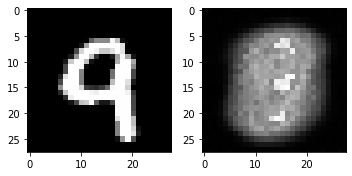

Epoch 1, Train Loss 1584361.3958333333, Valid Loss 0.07101523876190186 


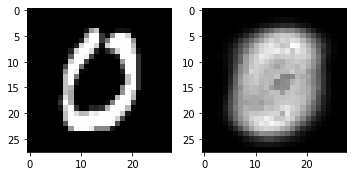

Epoch 2, Train Loss 1011927.359375, Valid Loss 0.06167489290237427 


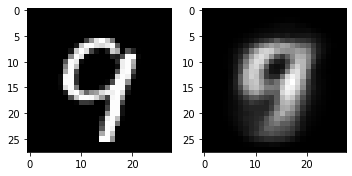

Epoch 3, Train Loss 912060.1041666666, Valid Loss 0.0516683105379343 


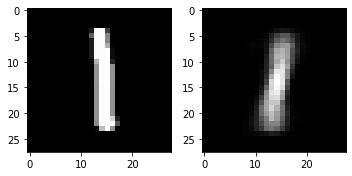

Epoch 4, Train Loss 812673.828125, Valid Loss 0.044353846460580826 


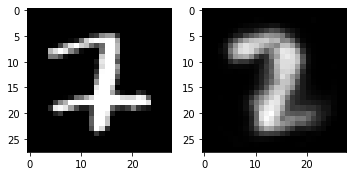

Epoch 5, Train Loss 725903.2395833334, Valid Loss 0.03696989826858044 


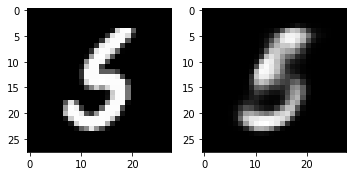

Epoch 6, Train Loss 664453.8958333334, Valid Loss 0.032843224704265594 


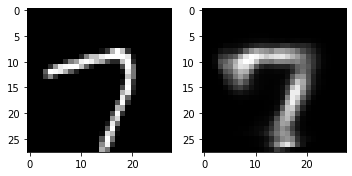

Epoch 7, Train Loss 617903.0104166666, Valid Loss 0.031076732091605663 


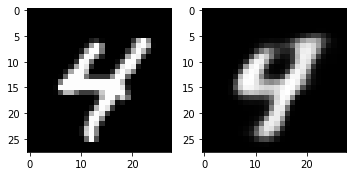

Epoch 8, Train Loss 587457.875, Valid Loss 0.02742758858948946 


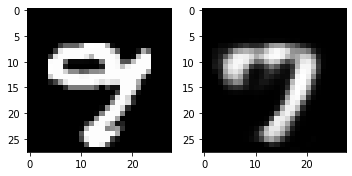

Epoch 9, Train Loss 559030.4791666666, Valid Loss 0.030133637599647045 


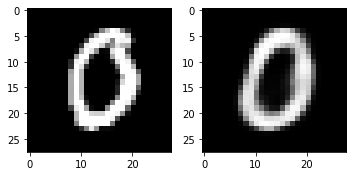

Epoch 10, Train Loss 555982.1510416666, Valid Loss 0.024262511171400547 


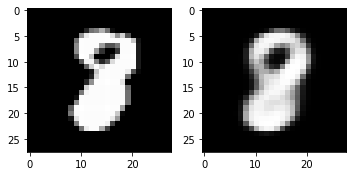

Epoch 11, Train Loss 522752.8802083333, Valid Loss 0.022227991372346878 


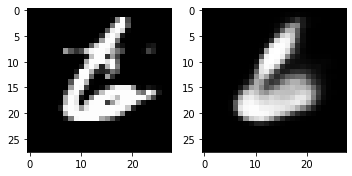

Epoch 12, Train Loss 510576.78125, Valid Loss 0.021850019693374634 


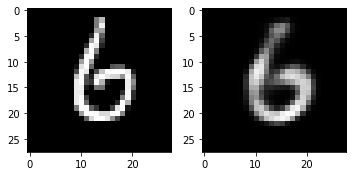

Epoch 13, Train Loss 494959.0911458333, Valid Loss 0.019782094284892082 


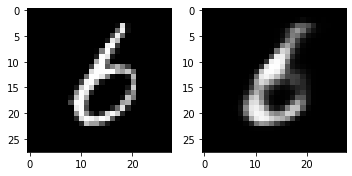

Epoch 14, Train Loss 478148.0989583333, Valid Loss 0.02027818374335766 


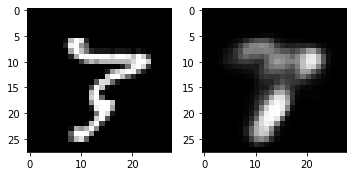

Epoch 15, Train Loss 488502.1458333333, Valid Loss 0.018501353450119495 


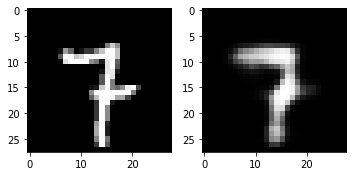

Epoch 16, Train Loss 460246.7005208333, Valid Loss 0.017136947251856327 


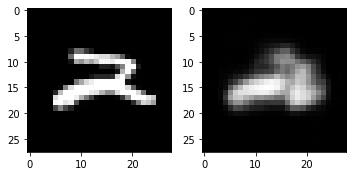

Epoch 17, Train Loss 448688.9192708333, Valid Loss 0.01753656007349491 


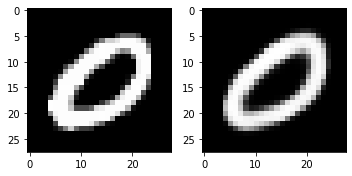

Epoch 18, Train Loss 448673.8984375, Valid Loss 0.016209842637181282 


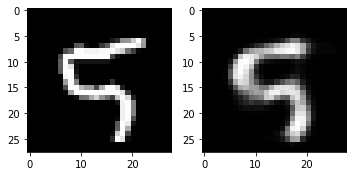

Epoch 19, Train Loss 431300.1015625, Valid Loss 0.014858933631330729 


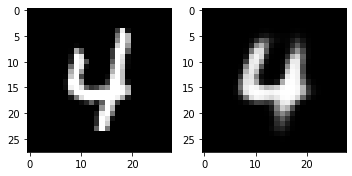

Epoch 20, Train Loss 443686.78125, Valid Loss 0.02181573398411274 


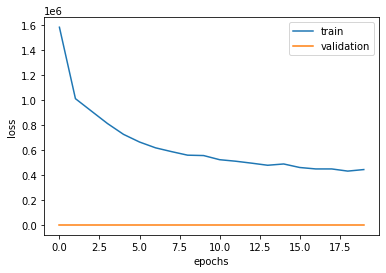

In [94]:
train_loss, val_loss = cvae_train(cvae, device,  optimizer, criterion, train_loader, val_loader, epochs=20)

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


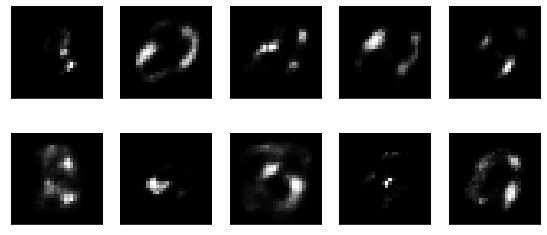

In [97]:
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])

NUMBER = 0 # какую цифру генерировать
label = [0 for i in range(10) ]
label[NUMBER] = 1
label = torch.FloatTensor([ [label] * 10]).view(10, 10)

output = cvae.decode(torch.FloatTensor(z).to(device), label.to(device))
out = output.data.cpu().numpy().reshape(-1, 28, 28)
plot_gallery(output.data.cpu().numpy().reshape(-1, 28, 28), 28, 28, n_row=2, n_col=5, channels=1)

In [24]:
label.size()

torch.Size([10, 10])

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [101]:
image, label = next(iter(val_loader))
digits = cvae.onehot_digits()
digit = digits[label].view(-1, 10)
mu, logsigma = cvae.encode(image.to(device), digit.to(device))
logsigma = logsigma.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()

tsne1 = TSNE().fit_transform(mu)
#tsne2 = TSNE().fit_transform(logsigma)

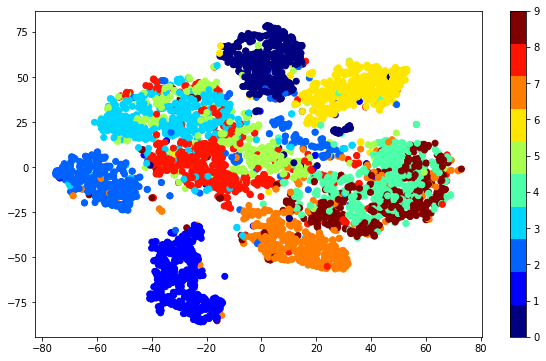

In [102]:
plt.figure(figsize=(10, 6))

plt.scatter(tsne1[:,0], tsne1[:,1], c=label, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar( )
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1000, shuffle = True)
val_loader = torch.utils.data.DataLoader(X_val, batch_size=3143)
all_data_loader = torch.utils.data.DataLoader(all_data, batch_size=len(data), shuffle = False)

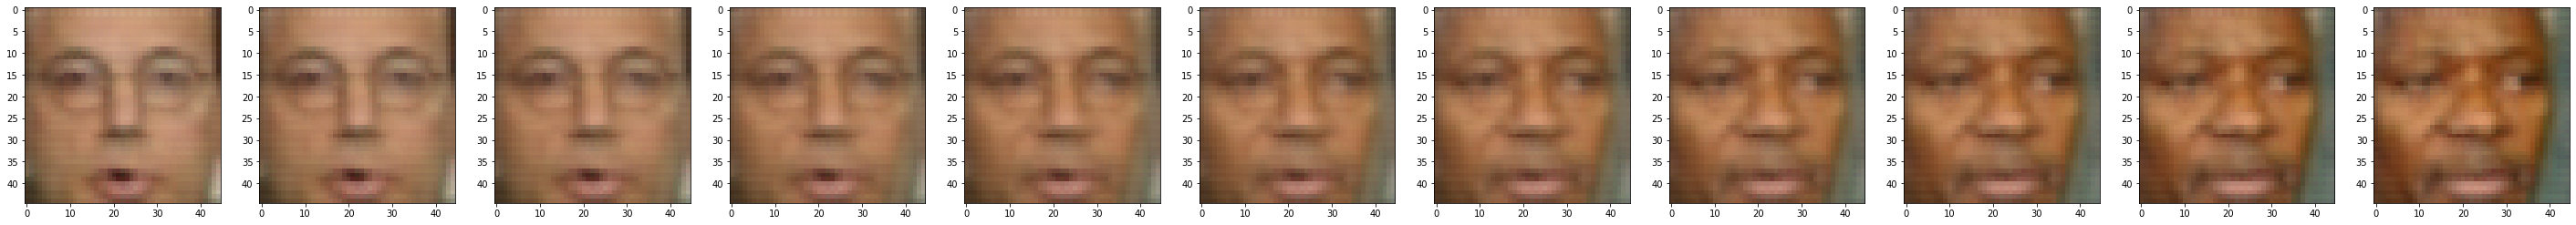

In [ ]:
pic1 = all_data[7587].view(1, 3, 45, 45)
pic2 = all_data[879].view(1, 3, 45, 45)

X = autoencoder.encoder1(pic1.to(device))
Y = autoencoder.encoder1(pic2.to(device))

alpha = np.array(list(range(11))) / 10
autoencoder.eval()

fig, axes = plt.subplots(nrows=1, ncols= len(alpha), figsize=(50, 50))
for i in range(len(alpha)):
    code = alpha[i] * X + (1 - alpha[i]) * Y
    result = autoencoder.decoder2(code).cpu().detach().view(3, 45, 45).numpy()
    result = np.rollaxis(result, 0, 3)
    axes[i].imshow(result)

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
# Добавляю шум в def noise_cvae_train ниже :)

In [122]:
def see_result(val, output):
    val = val.detach().numpy()
    output = output.detach().numpy()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(np.rollaxis(val, 0, 3))
    axes[1].imshow(np.rollaxis(output, 0, 3))
    fig.tight_layout()


def noise_vae_train(model, device, optimizer, criterion, trainloader, valloader, epochs=50, noise_factor=0.5):

    losses = []
    val_losses = []
    val_fn = nn.MSELoss()
    for e in range(epochs):
        
        epoch_loss = []
        model.train()
        for image in trainloader:

            noisy_image = (image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)).float() # noise
            optimizer.zero_grad()
         
            mu, logsigma, reconstruction = model(noisy_image.to(device), label.to(device))
            loss = criterion(image.to(device), mu, logsigma, reconstruction)
            epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        

        model.eval()
        with torch.no_grad():
            val_epoch_loss = []
            for val, label in valloader:
                noisy_val = (val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=val.shape)).float()
                mu, logsigma, reconstruction = model(noisy_val.to(device), label.to(device))
                
                
                val_epoch_loss.append( val_fn(  reconstruction, val.to(device)).item())
            
            val_losses.append(np.mean(val_epoch_loss))
            losses.append(np.mean(epoch_loss)) 

            plt.pause(0.05)
            rand = np.random.randint(0, len(val))
            see_result(noisy_val[rand].cpu(), reconstruction[rand].cpu())
            plt.pause(0.05)
            print(f'Epoch {e+1}, Train Loss {losses[-1]}, Valid Loss {val_losses[-1]} ')

    plt.plot(losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    return losses, val_losses

def noise_train(model, device, optimizer, criterion, trainloader, valloader, epochs=50, noise_factor=0.5):

    losses = []
    val_losses = []
    
    for e in range(epochs):
        
        epoch_loss = []
        model.train()
        for image in trainloader:
            optimizer.zero_grad()
            noisy_image = (image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)).float() # noise

            output, code = model(noisy_image.to(device))

            loss = criterion(output, image.to(device))
            epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            val_epoch_loss = []
            for val in valloader:
                noisy_val = (val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=val.shape)).float()
                output, code = model(noisy_val.to(device))
                val_epoch_loss.append( criterion(output, val.to(device)).cpu())
                                                    
            val_losses.append(np.mean(val_epoch_loss))
            losses.append(np.mean(epoch_loss)) 

            plt.pause(0.05)
            rand = np.random.randint(0, len(val))
            see_result(noisy_val[rand].cpu(), output[rand].cpu())
            plt.pause(0.05)
            print(f'Epoch {e+1}, Train Loss {losses[-1]}, Valid Loss {val_losses[-1]}')

    plt.plot(losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    return losses, val_losses

In [123]:
'''
from torchvision import transforms
from torchvision import datasets

transform = transforms.Compose([transforms.ToTensor(), ])

mnist_tr = datasets.MNIST('', download=True, train=True, transform=transform)
mnist_val = datasets.MNIST('', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_tr, batch_size=5000, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=5000, shuffle=True)'''

"\nfrom torchvision import transforms\nfrom torchvision import datasets\n\ntransform = transforms.Compose([transforms.ToTensor(), ])\n\nmnist_tr = datasets.MNIST('', download=True, train=True, transform=transform)\nmnist_val = datasets.MNIST('', download=True, train=False, transform=transform)\ntrain_loader = torch.utils.data.DataLoader(mnist_tr, batch_size=5000, shuffle=True)\nval_loader = torch.utils.data.DataLoader(mnist_val, batch_size=5000, shuffle=True)"

In [119]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1000, shuffle = True)
val_loader = torch.utils.data.DataLoader(X_val, batch_size=3143)
all_data = torch.utils.data.DataLoader(data, batch_size=128, shuffle = True)

In [124]:
criterion = nn.MSELoss()
ae = Autoencoder().to(device)
vae = LinearVAE(28).to(device)
optimizer = torch.optim.AdamW(ae.parameters(), amsgrad=True, lr = 0.01)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


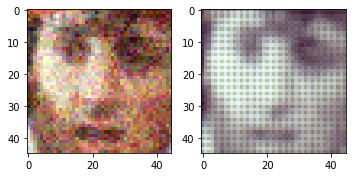

Epoch 1, Train Loss 0.919454675912857, Valid Loss 0.03544307127594948


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


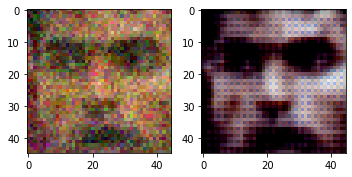

Epoch 2, Train Loss 0.6155707597732544, Valid Loss 0.07196101546287537


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


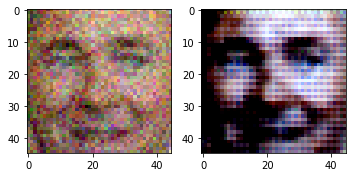

Epoch 3, Train Loss 0.43202255070209505, Valid Loss 0.1579141467809677


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


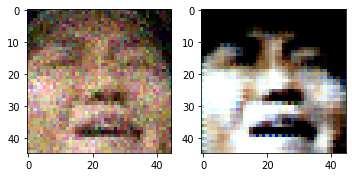

Epoch 4, Train Loss 0.2968700870871544, Valid Loss 0.15603314340114594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


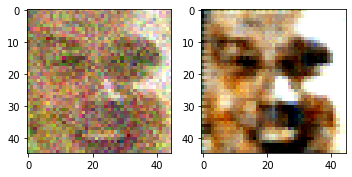

Epoch 5, Train Loss 0.19953978508710862, Valid Loss 0.1199297085404396


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


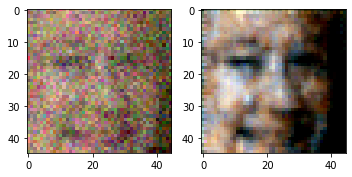

Epoch 6, Train Loss 0.13130540847778321, Valid Loss 0.08024969696998596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


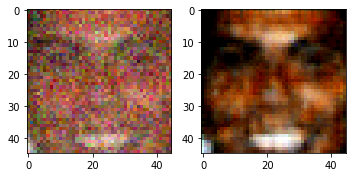

Epoch 7, Train Loss 0.08457835018634796, Valid Loss 0.05368248373270035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


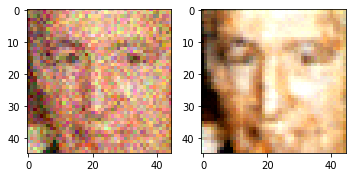

Epoch 8, Train Loss 0.053321272134780884, Valid Loss 0.03510419279336929


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


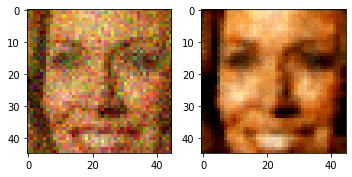

Epoch 9, Train Loss 0.032957167737185954, Valid Loss 0.02195124328136444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


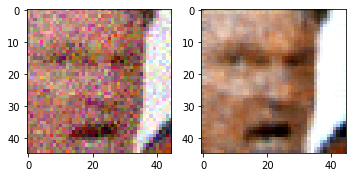

Epoch 10, Train Loss 0.020055308192968368, Valid Loss 0.013663196004927158


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


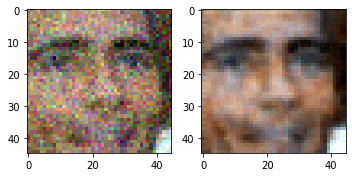

Epoch 11, Train Loss 0.01221924163401127, Valid Loss 0.008496643044054508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


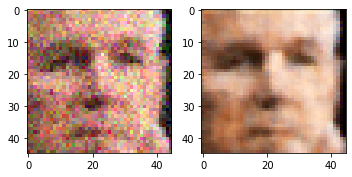

Epoch 12, Train Loss 0.007610126631334424, Valid Loss 0.005511741619557142


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


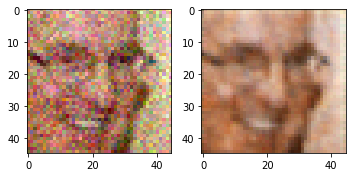

Epoch 13, Train Loss 0.005022828700020909, Valid Loss 0.0038775319699198008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


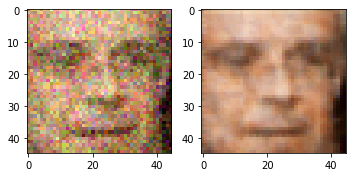

Epoch 14, Train Loss 0.0036239624256268143, Valid Loss 0.0029941683169454336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


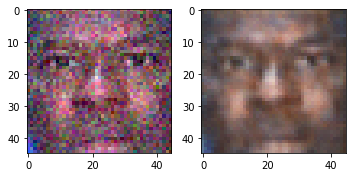

Epoch 15, Train Loss 0.0028982349205762146, Valid Loss 0.0025671119801700115


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


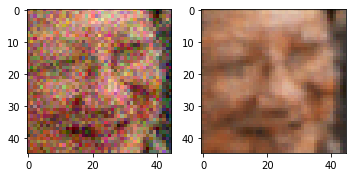

Epoch 16, Train Loss 0.002527976385317743, Valid Loss 0.002351338043808937


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


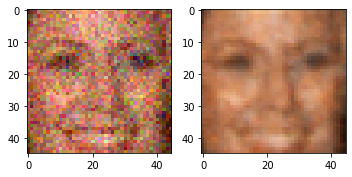

Epoch 17, Train Loss 0.002346281916834414, Valid Loss 0.002253309590741992


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


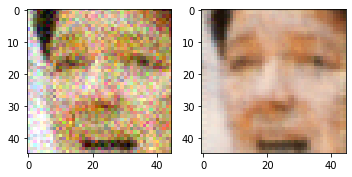

Epoch 18, Train Loss 0.0022592225577682257, Valid Loss 0.002205271041020751


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


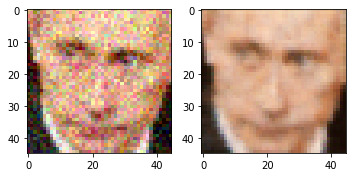

Epoch 19, Train Loss 0.002216611197218299, Valid Loss 0.002182475058361888


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


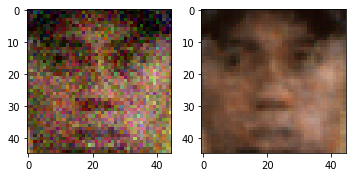

Epoch 20, Train Loss 0.002186247380450368, Valid Loss 0.0021673033479601145


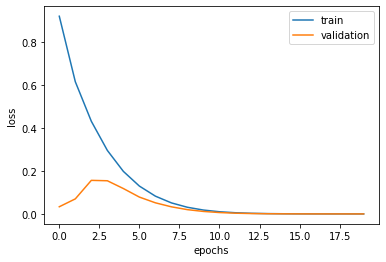

In [126]:
train_loss, val_loss = noise_train(ae, device,  optimizer, criterion, train_loader, val_loader, 20, 0.1)

device(type='cuda')

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
<тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!